In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Walls need to be ambient temperature

In [3]:
# CONSTANTS
tubL, tubW, tubH = 1.20, 0.60, 0.40 # meters
countL, countW, countH = 24, 12, 8 # dimensionless
molWaterInM3 = 55493.9 # mol / meter^3
humanCP = 3500 # J / kg K 
humanRho = 985 # kg / m ^ 3
humanThermalDiffusivity = 2.8e-8
humanTemp = 37 # deg C <- 98.6 deg F

bathWallThermalDiffusivity = 22e-6 # cast iron thermal diffusivity
bathWallThermalConductivity = 55 # cast iron W/m K
bathWallSpecificHeat = 500 # J / kg K
bathWallThickness = 5e-3 # cast iron thickness, m
bathWallDensity = 7170 # cast iron density, kg/m^3

In [4]:
# VARIABLES
waterEntry = (1, 1, 1)
waterExit = (2, 2, 2)
waterInputTemp = 40.0 # deg celsius
waterStartingTemp = 37.0 # deg celsius
ambientTemp = 20.0 # deg celsius
kMetal = 0.05

dt = 0.1 # seconds

In [5]:
# DERIVED
distL, distW, distH = tubL/countL, tubW/countW, tubH/countH
saL, saW, saH = distW*distH, distL*distH, distL*distW
wallWtL = saL * (bathWallThickness*bathWallDensity) # kg
wallWtW = saW * (bathWallThickness*bathWallDensity) # kg
wallWtH = saH * (bathWallThickness*bathWallDensity) # kg
#kMetalL = bathWallThermalConductivity / ((bathWallThickness ** 2) * bathWallSpecificHeat * bathWallDensity) # SA * TC / TH * [J/K]
#print(saL, kMetalL)

In [11]:
def getWaterCP(temp):
    return (75.98 - 0.061 * temp + 0.002 * (temp ** 2) - 0.00001755 * (temp ** 3))
def getWaterThermCond(temp):
    return (0.561 + 0.002 * temp + 0.00000962 * (temp ** 2))
def getWaterDensity(temp):
    return (999.86 + 0.058 * temp - 0.008 * (temp ** 2) + 0.0000397 * (temp ** 3))
def getWaterDiffusivity(temp):
    return getWaterThermCond(temp) / (getWaterCP(temp) * getWaterDensity(temp))
def getSubsectionVolumeMols():
    return molWaterInM3 * (tubL/countL) * (tubW/countW) * (tubH/countH)
def getSubsectionVolumeMeters():
    return (tubL/countL) * (tubW/countW) * (tubH/countH)

def cellIsHuman(l, w, h):
    if countL != 24 or countW != 12 or countH != 8: raise Exception("Too bad, so sad.")
    if l >= 1 and l <= 4: 
        if w >= 4 and w <= 9: return True
    elif l >= 5 and l <= 14 and (h == 6 or h == 7):
        if w == 4 or w == 5 or w == 8 or w == 9: return True
    elif l >= 15 and l <= 21 and h == 7:
        if w == 5 or w == 8: return True        
    return False

In [12]:
def getNewTempArray():
    return waterStartingTemp*np.ones((countL+2, countW+2, countH+1))

def getTubSafe(tub, l, w, h):
    l = 0        if l < 0        else l
    l = countL+1 if l > countL+1 else l
    w = 0        if w < 0        else w
    w = countW+1 if w > countW+1 else w
    h = 0        if h < 0        else h
    h = countH+0 if h > countH+0 else h
    return tub[l][w][h]

def getPointDiffusivity(tub, l, w, h):
    if l == 0 or l == countL+1: return bathWallThermalDiffusivity
    if w == 0 or w == countW+1: return bathWallThermalDiffusivity
    if           h == countH+0: return bathWallThermalDiffusivity # h = 0 layer is water
    return getWaterDiffusivity(tub[l][w][h])

def getCellLagrangian(tub, l, w, h):
    ddL = float(getTubSafe(tub, l+1, w, h) + getTubSafe(tub, l-1, w, h) - 2 * getTubSafe(tub, l, w, h)) / (distL ** 2)
    ddW = float(getTubSafe(tub, l, w+1, h) + getTubSafe(tub, l, w-1, h) - 2 * getTubSafe(tub, l, w, h)) / (distW ** 2)
    ddH = float(getTubSafe(tub, l, w, h+1) + getTubSafe(tub, l, w, h-1) - 2 * getTubSafe(tub, l, w, h)) / (distH ** 2)
    return ddL + ddW + ddH

def cellStep(tub):
    newTub = np.copy(tub)
    for l in range(0, countL+2):
        for w in range(0, countW+2):
            for h in range(0, countH+1):
                wd = getPointDiffusivity(tub, l, w, h)
                dd = getCellLagrangian(tub, l, w, h)
                mm = getSubsectionVolumeMols()
                if cellIsHuman(l, w, h): newTub[l][w][h] = humanTemp
                else: newTub[l][w][h] += dt*mm*wd*dd
                    
                if l == 0 or w == 0 or l == countL+1 or w == countW+1 or h == countH:
                    # h == 0 is water and is excluded from metal decay
                    newTub[l][w][h] += -0.20*dt*(newTub[l][w][h]-ambientTemp)
                if h == 0 and l != 0 and w != 0:
                    # this is the upper surface of the water
                    newTub[l][w][h] += -2.8 * dt * (saH / (getWaterCP(tub[l][w][h]) * getSubsectionVolumeMols())) * (tub[l][w][h] - ambientTemp)
    return newTub

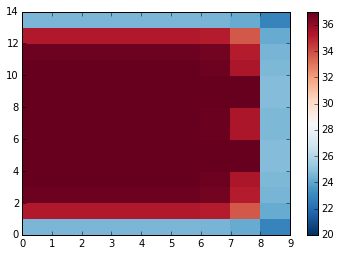

In [15]:
arr = getNewTempArray();

def plot_fn(steps=1, depth=1, dtx=0.1):
    dt = dtx
    arr = getNewTempArray()
    for i in range(0, steps):
        arr = cellStep(arr)
    #print(arr)
    plt.pcolor(arr[depth], cmap='RdBu_r', vmin=20, vmax=37)
    plt.colorbar()

interact(plot_fn, steps=(1, 100), depth=(0,25), dtx=(0.1,5,0.1))

In [10]:
print(saL, saW, saH)
print(wallWtL, wallWtW, wallWtH)

tmp = list(itertools.product(*[[x for x in range(0, countL+1)],[x for x in range(0, countW+1)], [x for x in range(0, countH)]]))
for i in tmp:
    print(i, cellIsHuman(i[0], i[1], i[2]))

(0.0025, 0.0025, 0.0024999999999999996)
(0.08962500000000001, 0.08962500000000001, 0.089625)
((0, 0, 0), False)
((0, 0, 1), False)
((0, 0, 2), False)
((0, 0, 3), False)
((0, 0, 4), False)
((0, 0, 5), False)
((0, 0, 6), False)
((0, 0, 7), False)
((0, 1, 0), False)
((0, 1, 1), False)
((0, 1, 2), False)
((0, 1, 3), False)
((0, 1, 4), False)
((0, 1, 5), False)
((0, 1, 6), False)
((0, 1, 7), False)
((0, 2, 0), False)
((0, 2, 1), False)
((0, 2, 2), False)
((0, 2, 3), False)
((0, 2, 4), False)
((0, 2, 5), False)
((0, 2, 6), False)
((0, 2, 7), False)
((0, 3, 0), False)
((0, 3, 1), False)
((0, 3, 2), False)
((0, 3, 3), False)
((0, 3, 4), False)
((0, 3, 5), False)
((0, 3, 6), False)
((0, 3, 7), False)
((0, 4, 0), False)
((0, 4, 1), False)
((0, 4, 2), False)
((0, 4, 3), False)
((0, 4, 4), False)
((0, 4, 5), False)
((0, 4, 6), False)
((0, 4, 7), False)
((0, 5, 0), False)
((0, 5, 1), False)
((0, 5, 2), False)
((0, 5, 3), False)
((0, 5, 4), False)
((0, 5, 5), False)
((0, 5, 6), False)
((0, 5, 7), Fa